In [4]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ["export CUDA_VISIBLE_DEVICES"] = '0'

# 数据加载

In [30]:
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')

target = ['Group']
cat_feats = ['sex', 'ISS', 'ecog', 'bonelesion'] #'sex', 'ISS', 'ecog', 'bonelesion'
dense_feats = ['age', 'BUN', 'Totalprotein', 'Glucose', 'Hb', 'PLT', 'ALB', 'LDH', 'Cr', 'Ca', 'B2MG', 'ANC', 'WBC']

print(train.columns.tolist())

['sex', 'age', 'ISS', 'ecog', 'bonelesion', 'BUN', 'Totalprotein', 'Glucose', 'Hb', 'PLT', 'ALB', 'LDH', 'Cr', 'Ca', 'B2MG', 'ANC', 'WBC', 'Group']


# 数据预处理

In [31]:
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
def process(df, cat_feats, dense_feats, is_process_null=True, is_normalize=True, inplace=False, dense_transformer=None, target="Group", le=None):
    """
    数据处理。
    1. 填补缺失值;
    2. 将类别变量展开为 one-hot;
    3. 数值特征的处理;
    4. 类别不平衡处理;
    """
    if not inplace:
        df = df.copy()
    
    for col in df.columns:
        if df[col].dtype == object and col != target:
            df[col][~df[col].apply(lambda x: type(x)).isin([float, int])] = np.nan
    
    if is_process_null:
        # 填补缺失值
        for col in df.columns:
            num_null = df[col].isnull().sum()
            if num_null == 0:
                continue
            if col in cat_feats:
                value = df[col].value_counts().sort_values(ascending=False).index[0]
            else:
                value = df[col].quantile(q=0.5)
            df[col].fillna(value=value, inplace=True)
    
    # 处理类别特征
    for cf in cat_feats:
        tmp = pd.get_dummies(df[cf])
        tmp.columns = [f"{cf}_{i}" for i in range(tmp.shape[1])]
        df = pd.concat([df, tmp], axis=1)
        
    df.drop(cat_feats, inplace=True, axis=1)
    
    if is_normalize:
        # 处理数值特征
#         transformers = {}
#         for denf in dense_feats:
#             scaler = preprocessing.StandardScaler().fit(df[denf].values.reshape((-1, 1)))
#             transformers[denf] = scaler
#             df[denf] = scaler.transform(df[denf].values)
        df = df.astype(dict(zip(dense_feats, [float]*len(dense_feats))))
        if not dense_transformer:
            scaler = preprocessing.StandardScaler().fit(df[dense_feats].values)
        else:
            scaler = dense_transformer
        df[dense_feats] = scaler.transform(df[dense_feats])
        transformer = scaler
    else:
        transformer = None
        
    # 对目标变量进行编码
    if le is None:
        le = preprocessing.LabelEncoder().fit(df[target])
    df[target] = le.transform(df[target])
    
    # 处理类别不平衡

    
    return df, transformer, le

# 第一种数据预处理

In [32]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,SMOTEN
from collections import Counter

ptra, trans, le = process(train, cat_feats, dense_feats)
ptes, *_ = process(test, cat_feats, dense_feats, dense_transformer=trans, le=le)

y = ptra['Group'].values
ptra.drop(target, axis=1, inplace=True)
X = ptra.values
x_train, y_train = X, y

y_test = ptes[target].values
ptes.drop(target, axis=1, inplace=True)
x_test = ptes.values

# 降维
# pca = PCA(n_components=5)
# X_vis=pca.fit_transform(x_train)

#以使用imblearn进行随机过采样
# sm=RandomUnderSampler(random_state=0)
sm = SMOTE()
X_resampled, y_resampled=sm.fit_resample(x_train, y_train)
# X_res_vis=pca.transform(X_resampled)
x_train, y_train = X_resampled, y_resampled
Counter(y_resampled)
# x_test = pca.transform(x_test)

Counter({1: 240, 0: 240})

# 第二种数据预处理

In [5]:
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,SMOTEN

file_train = pd.read_excel("train.xlsx").fillna(value=0)
file_test = pd.read_excel("test.xlsx").fillna(value=0)
file_train["Glucose"] = file_train["Glucose"].apply(lambda x: 0 if type(x) == str else float(x))
file_train["BUN"] = file_train["BUN"].apply(lambda x: 0 if type(x) == str else float(x))
file_test["Glucose"] = file_test["Glucose"].apply(lambda x: 0 if type(x) == str else float(x))
file_test["BUN"] = file_test["BUN"].apply(lambda x: 0 if type(x) == str else float(x))
file_test["Group"] = file_test["Group"].apply(lambda x: 1 if x == "FHR" else 0)
file_train["Group"] = file_train["Group"].apply(lambda x: 1 if x == "FHR" else 0)


x_train = file_train.iloc[:, :-1]
y_train = file_train["Group"].astype(np.int64)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = file_test.iloc[:, :-1]
y_test = file_test["Group"].astype(np.int64)

x_test = np.array(x_test)
y_test = np.array(y_test)
std_x_train = StandardScaler().fit_transform(x_train)
std_x_test = StandardScaler().fit_transform(x_test)

#以使用imblearn进行随机过采样为例
# sm = SMOTE()
# X_resampled, y_resampled=sm.fit_resample(x_train, y_train)
# x_train, y_train = X_resampled, y_resampled

# #查看结果
# Counter(y_resampled) 

# XGBoost 寻优

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier(eval_metric=['auc']))])
params = {

    'classifier__min_child_weight': [0.5, 0.8, 1, 5, 10],
    'classifier__eta': np.linspace(0.01,2,20),
    # 'classifier__base_score': np.linspace(0.01,0.99,20),
    #
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],
    #
    'classifier__subsample': [0.4, 0.6, 0.8, 1.0, 1.2, 1.4],
    #
    'classifier__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    #
    'classifier__max_depth': range(1,10)

}

random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END classifier__colsample_bytree=0.8, classifier__eta=2.0, classifier__gamma=5, classifier__max_depth=1, classifier__min_child_weight=5, classifier__subsample=0.6;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__colsample_bytree=0.8, classifier__eta=2.0, classifier__gamma=5, classifier__max_depth=1, classifier__min_child_weight=5, classifier__subsample=0.6;, score=0.438 total time=   0.0s
[CV 3/5] END classifier__colsample_bytree=0.8, classifier__eta=2.0, classifier__gamma=5, classifier__max_depth=1, classifier__min_child_weight=5, classifier__subsample=0.6;, score=0.646 total time=   0.0s
[CV 4/5] END classifier__colsample_bytree=0.8, classifier__eta=2.0, classifier__gamma=5, classifier__max_depth=1, classifier__min_child_weight=5, classifier__subsample=0.6;, score=0.542 total time=   0.0s
[CV 5/5] END classifier__colsample_bytree=0.8, classifier__eta=2.0, classifier__gamma=5, classifier__max_depth=1, cl

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

result =  1
best_auc = 0
for i in np.linspace(0.001,0.9,1000):

    xgb_clf = XGBClassifier(subsample=0.8, min_child_weight=1, classifier__max_depth=5, classifier__gamma=0.5,
                        classifier__colsample_bytree=1.0,eta=0.32,base_score=i)
    xgb_clf.fit(x_train, y_train)
    xgb_y_pred = xgb_clf.predict(x_test)
    y_pred_proba = xgb_clf.predict_proba(x_test)
    print(xgb_clf.score(x_test, y_test))
    print(xgb_clf.score(x_train, y_train))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    xgb_auc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])

    if xgb_auc_score >best_auc:
        best_auc = xgb_auc_score
        result = i

print(result,best_auc)

[19:30:22] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:30:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.25626204238921
0.5
[19:30:22] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or

# DecisionTreeClassifier 寻优

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# DecisionTreeClassifier().get_params().keys()
dt = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best','random'],
    'min_samples_leaf': range(1,20),
    'max_depth': range(1,20)
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=entropy, max_depth=16, min_samples_leaf=16, splitter=random;, score=0.800 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=16, min_samples_leaf=16, splitter=random;, score=0.800 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=16, min_samples_leaf=16, splitter=random;, score=0.800 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=16, min_samples_leaf=16, splitter=random;, score=0.800 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=16, min_samples_leaf=16, splitter=random;, score=0.814 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=1, min_samples_leaf=9, splitter=random;, score=0.800 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=1, min_samples_leaf=9, splitter=random;, score=0.800 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=1, min_samples_leaf=9, splitter=random;, score=0.800 total time=   0.0s
[CV 4/5] END c

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# DecisionTreeClassifier().get_params().keys()
dt = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best','random'],
    'min_samples_leaf': range(1,20),
    'max_depth': range(1,20)
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

result =  1
best_auc = 0
for i in np.linspace(0.001,0.9,1000):

    xgb_clf = XGBClassifier(subsample=0.8, min_child_weight=1, classifier__max_depth=5, classifier__gamma=0.5,
                        classifier__colsample_bytree=1.0,eta=0.32,base_score=i)
    xgb_clf.fit(x_train, y_train)
    xgb_y_pred = xgb_clf.predict(x_test)
    y_pred_proba = xgb_clf.predict_proba(x_test)
    print(xgb_clf.score(x_test, y_test))
    print(xgb_clf.score(x_train, y_train))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    xgb_auc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])

    if xgb_auc_score >best_auc:
        best_auc = xgb_auc_score
        result = i

print(result,best_auc)

# RandomForestClassifier 寻优

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# RandomForestClassifier().get_params().keys()
dt = RandomForestClassifier(random_state=30)
params = {
    'n_estimators': range(1,200,1),
    'min_samples_leaf':np.arange(1, 30, 1),
    'min_samples_split':np.arange(2, 2+20, 1),
    'criterion':['gini', 'entropy'],
    'max_features':np.arange(5,30,1),
    'max_depth':np.arange(1, 20, 1),
    'max_leaf_nodes':np.arange(25,50,1),
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=gini, max_depth=19, max_features=10, max_leaf_nodes=45, min_samples_leaf=12, min_samples_split=14, n_estimators=130;, score=0.800 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=19, max_features=10, max_leaf_nodes=45, min_samples_leaf=12, min_samples_split=14, n_estimators=130;, score=0.800 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=19, max_features=10, max_leaf_nodes=45, min_samples_leaf=12, min_samples_split=14, n_estimators=130;, score=0.800 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=19, max_features=10, max_leaf_nodes=45, min_samples_leaf=12, min_samples_split=14, n_estimators=130;, score=0.800 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=19, max_features=10, max_leaf_nodes=45, min_samples_leaf=12, min_samples_split=14, n_estimators=130;, score=0.814 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=19, max_leaf_nodes

# 多模型比较

In [69]:
# 模型性能评估
from sklearn.metrics import confusion_matrix

def show_matrics(y_test, y_pred, labels=['0', '1']):
	conf_matrix = confusion_matrix(y_test, y_pred)
    # 根据混淆矩阵，获取对应的参数值
	TP = conf_matrix[1, 1]
	FN = conf_matrix[1, 0]
	FP = conf_matrix[0, 1]
	TN = conf_matrix[0, 0]
	show_metrics = [[FN, FP], [TN, TP]]
	fig, ax = plt.subplots(figsize=(8, 8))
	img = ax.imshow(show_metrics, cmap=plt.get_cmap("Blues"))
	n = len(labels)
	ax.set_title('Confusion Matrix')
	ax.set_xticks(range(n))
	ax.set_xticklabels(labels)
	ax.set_yticks(range(n))
	ax.set_yticklabels(labels)
	ax.set_xlabel('Predicted Label')
	ax.set_ylabel('True Label')
	for i in range(n):
		for j in range(n):
			text = f"{show_metrics[i][j]}"
			plt.text(j, i, text, horizontalalignment="center",
					 color="red")
	
	plt.colorbar(img)
	plt.show()

[18:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:01:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:17] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actua

<Figure size 432x288 with 0 Axes>

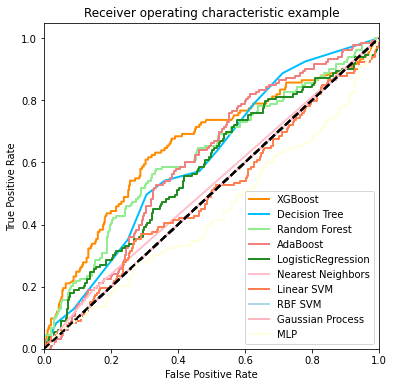

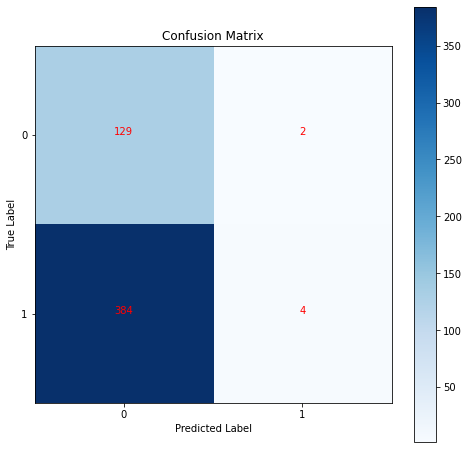

模型Decision Tree：Acc值为：0.74 	 AUC值为0.55


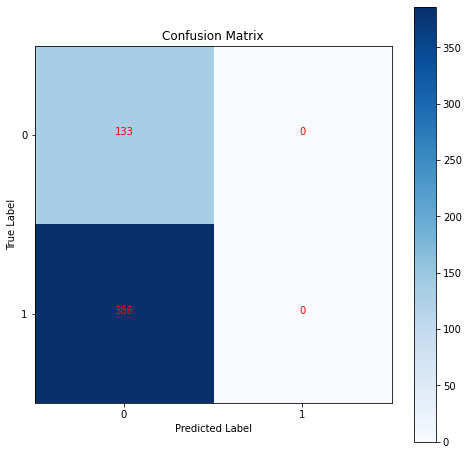

模型Random Forest：Acc值为：0.74 	 AUC值为0.62


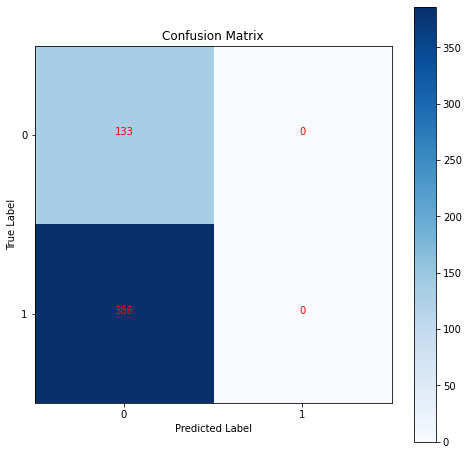

模型AdaBoost：Acc值为：0.71 	 AUC值为0.51


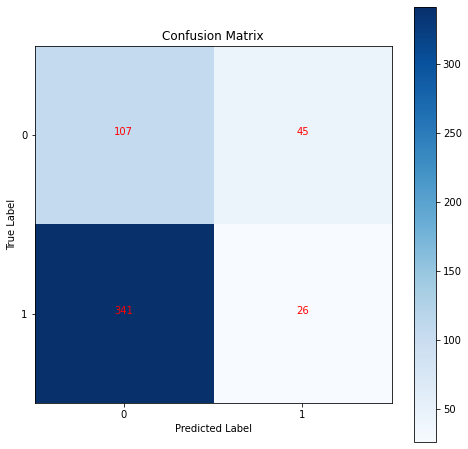

模型LogisticRegression：Acc值为：0.74 	 AUC值为0.58


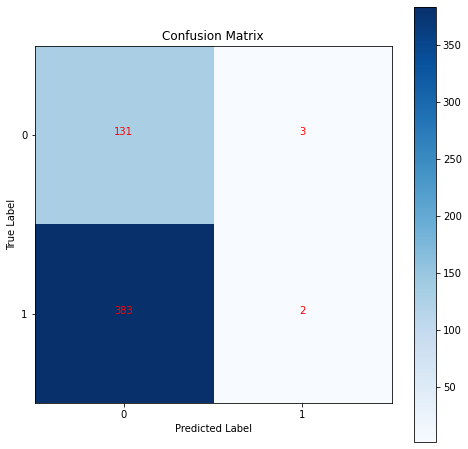

模型Nearest Neighbors：Acc值为：0.68 	 AUC值为0.52


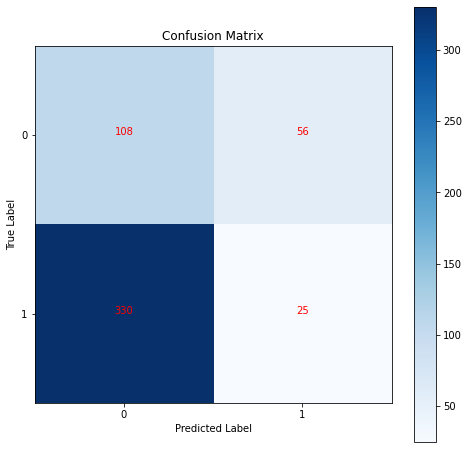

模型Linear SVM：Acc值为：0.74 	 AUC值为0.50


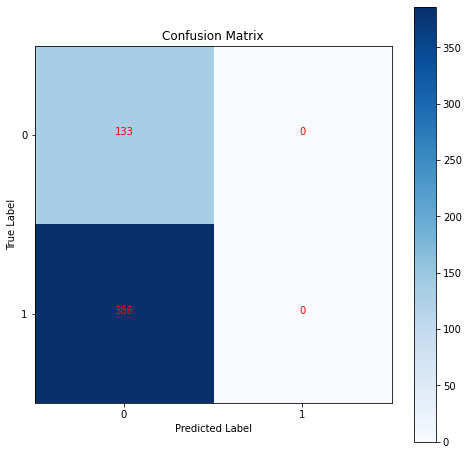

模型RBF SVM：Acc值为：0.74 	 AUC值为0.50


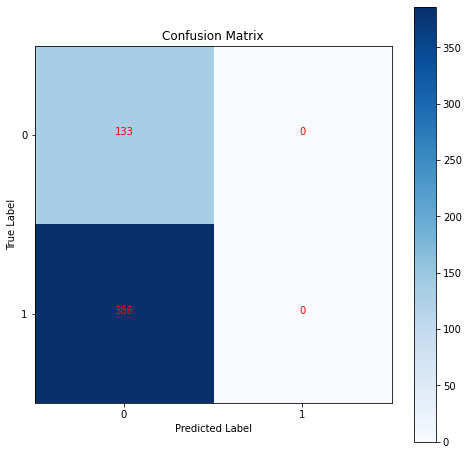

模型Gaussian Process：Acc值为：0.70 	 AUC值为0.50


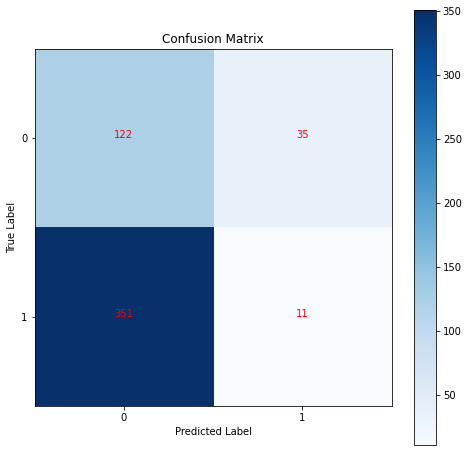

模型MLP：Acc值为：0.58 	 AUC值为0.37


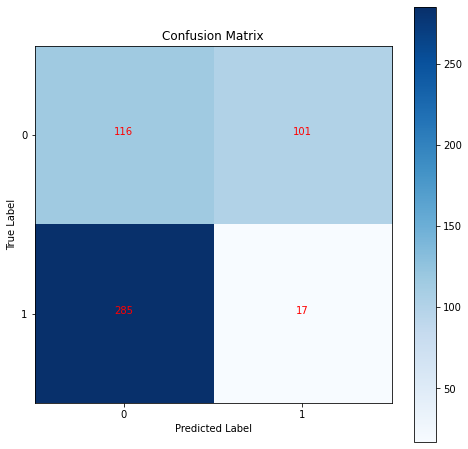

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pylab import mpl
import seaborn as sns
plt.figure(facecolor='snow')
font_size = 12

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [ "XGBoost",
         "Decision Tree", "Random Forest", "AdaBoost", "LogisticRegression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", "MLP",
         "Naive Bayes", "QuadraticDiscriminantAnalysis"]
#n_estimators=100, random_state=0, algorithm="SAMME",learning_rate=0.1
classifiers = [
    XGBClassifier(subsample=0.2, min_child_weight=5, classifier__max_depth=7, classifier__gamma=0.73,
                        classifier__colsample_bytree=1,eta= 0.31,base_score=0.66515),
    DecisionTreeClassifier(splitter='random', min_samples_leaf=16, max_depth=16, criterion='entropy'),
    RandomForestClassifier(n_estimators= 130, min_samples_split= 14, min_samples_leaf= 12, max_leaf_nodes= 45, max_features=10, max_depth=19, criterion='gini'),
    AdaBoostClassifier(DecisionTreeClassifier(splitter='random', min_samples_leaf=16, max_depth=16, criterion='entropy')),
    LogisticRegression(random_state=1),
    KNeighborsClassifier(1),
    SVC(kernel="linear", C=0.025,probability=True),
    SVC(gamma=0.73, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=0.7, max_iter=1000)]
    # GaussianNB(),
    # QuadraticDiscriminantAnalysis()]
plt.figure(figsize=(6,6))
i = 0
colors = ['darkorange','deepskyblue','lightgreen','lightcoral','forestgreen','pink','coral','lightblue', 'lightpink', 'lightyellow']
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=colors[i],
        lw=lw,
        label=name, #+"ROC curve (area = %0.2f)" % auc_score
    )
    i += 1
    plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    # plt.savefig('auc_roc.pdf')
    # plt.show()

for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    auc_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    print(f"模型%s：Acc值为：%.2f \t AUC值为%.2f"%(name,clf.score(x_test, y_test), auc_score))
    show_matrics(y_test.squeeze(), y_pred)
